In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

from numpy.random import seed
from keras.optimizers import SGD

import pickle

## Context: the tracer test as forward in the inverse problem

We generated a synthetic geological 2D reference which contains 4 geological facies.
With each facies a permeability, conductivity and specific storage valueis uniquely assigned.
The permeability, conductivity and specific storage are parameters needed to solve transport problem of a tracer, which is injected at x=25, y=50. A pumping well is placed at x=75, y=50 and concentration of the tracer is measured during 20 days.
A geology maps uniquely to the concentration curve. Then, the concentration curve is used to compute the likelihood of the model.

During the solution of the inverse problem, geological models are generated and the concentration curve is computed for each model using MODFLOW with transport module. However, MODFLOW computation is very expensive (around 30 min per simulation). We would like to limit the number of MODFLOW calls. First, we generate 1000 pairs geology and concentration. Using this dataset, we want to train a ML model that would estimate the likelihood of new models.

The goal is to use Machine Learning (ML) to map from the geology 2D categorical image 100x100 to the likelihood (scalar value).

In [2]:
with open('ref/ref-img-val.pickle', 'rb') as file_handle:
    img_ref = pickle.load(file_handle)

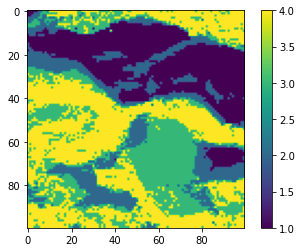

In [3]:
# the reference geology
plt.imshow(img_ref)
plt.colorbar()

In [4]:
with open('ref/measurement-4.pickle', 'rb') as file_handle:
    concentrations_ref = pickle.load(file_handle)

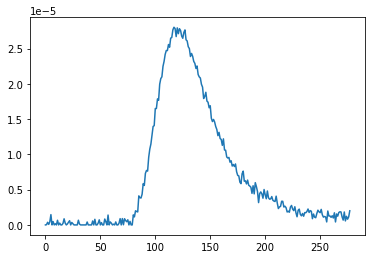

In [5]:
# the reference concentration curve
plt.plot(concentrations_ref[:])

For computation of the likelihood only 6 values sampled from the concentration cruve are used.
They are sampled at the following indexes:

In [6]:
ind = [50, 100, 125, 150, 200, 250]

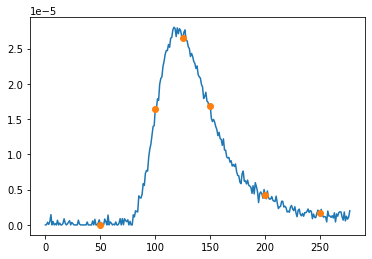

In [7]:
# the reference concentration curve
plt.plot(concentrations_ref[:])
plt.plot(ind, concentrations_ref[ind], 'o')

We can either use ML to estimate the likelihood directly, or try to estimate the 6 values on the concentration curve.

I propose the following approach: generate indicators for 3 facies of the model. It results in (100,100,3) array for each model, filled with 1 and 0. Then train a ML estimator on data containing 6 concentration values normalized between 0 and 1.

## The dataset

In [8]:
# helper popex object
with open(f'popex/popex.pop', 'rb') as file_handle:
    popex = pickle.load(file_handle)
    
N_POPEX = 1000

In [9]:
def get_pickle(name):
    result = None
    try:
        with open(name, 'rb') as file_handle:
            result = pickle.load(file_handle)
    except FileNotFoundError as e:
        print(f'{name} failed: {str(e)}')
    return result

In [10]:
# load "good" concentrations
concentration_tuple = tuple(get_pickle(f'concentrations/flow-{i}-concentration.pickle') for i in range(N_POPEX))

In [11]:
model_tuple = tuple(get_pickle(f'popex/{i}') for i in popex.model[:N_POPEX])
img_tuple = tuple(i[0].param_val.reshape((100,100)) for i in model_tuple)

In [12]:
# log likelihoods are also available
likelihood_tuple = tuple(popex.log_p_lik[:N_POPEX])

likelihoods can be computed by `-np.sum( ((ref_concentration[ind] - concentration[ind])**2)) /(2*(0.05e-5)**2)`

The input data is in img_tuple (1000 examples). The full output (concentraion curves) is in concentration_tuple

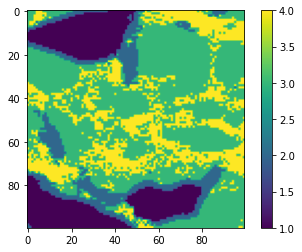

In [13]:
# example input image
plt.imshow(img_tuple[0])
plt.colorbar()

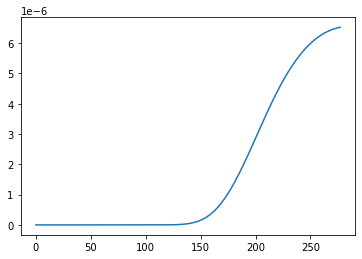

In [14]:
# example concentration curve
plt.plot(concentration_tuple[0])

### Convert input to indicators and sample from output

In [15]:
def indicator(img, facies):
    output = np.zeros_like(img,dtype='float32')
    output[img==facies] = 1.0
    return output

In [16]:
def indicator_array(img):
    return np.stack((indicator(img, i) for i in range(4,1,-1)), axis=2)

In [17]:
# All input data
X = np.stack(indicator_array(img) for i, img in enumerate(img_tuple))
X.shape

/home/judap/source/miniconda3/envs/ml-popex/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
/home/judap/source/miniconda3/envs/ml-popex/lib/python3.8/site-packages/numpy/core/shape_base.py:421: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  arrays = [asanyarray(arr) for arr in arrays]


(1000, 100, 100, 3)

Let's take the fourth image and its indicator of 2nd facies.

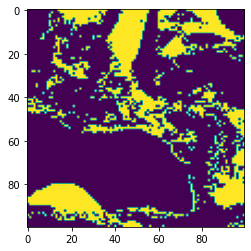

In [18]:
plt.imshow(X[3,:,:,1])

In [19]:
# now the outputs
concentrations_sampled = np.stack(c[ind] for c in concentration_tuple)

In [20]:
scaler = MinMaxScaler()
scaler.fit(concentrations_sampled)
y = scaler.transform(concentrations_sampled)
y.shape

(1000, 6)

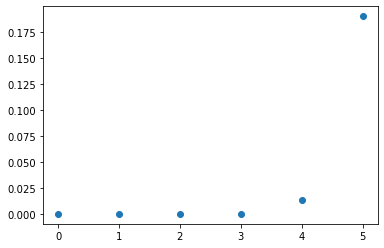

In [21]:
# Take 4th example
plt.plot(y[3,:], 'o')

### Split train-validation

We use train-validations split 900-100. We will perform the testing of different models on new data.

In [22]:
# define the size of the training, validation and test sets
trainingSize = int(0.9 * N_POPEX)
valSize      = N_POPEX - trainingSize

In [23]:
X_train = X[:trainingSize].copy()
X_val = X[trainingSize:trainingSize+valSize].copy()

y_train = y[:trainingSize].copy()
y_val = y[trainingSize:trainingSize+valSize].copy()

## CNN 

I use essentially the same set-up as in Yasin's prevoius study. The main difference: I have three input channels. Then, for the last layer, I use relu activation, as I do not want negative values of concentration

In [24]:
modelCNN = Sequential()
modelCNN.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))
modelCNN.add(Conv2D(64, (3, 3), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.25))
modelCNN.add(Flatten())
modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(6,activation="relu"))

opt = SGD(lr=0.01) # optimiser
modelCNN.compile(loss=keras.losses.mse,
              optimizer=opt,
              metrics=['mse'])


In [25]:
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [26]:
# fit a model and validate using the validation dataset 
seed(1)
historyCNN= modelCNN.fit(X_train, y_train,
          batch_size=10,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 2/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 3/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 4/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 5/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 6/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 7/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 8/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0347 - mse: 0.03

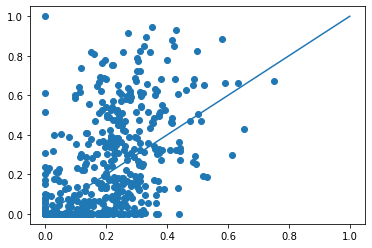

In [27]:
y_pred_CNN = modelCNN.predict(X_val)
plt.scatter(y_pred_CNN.flatten(), y_val.flatten())
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

## Feed-forward NN

I flatten the data first. Then, I use the set-up of Yasin wih the last layer 'relu' to avoid negative values.

In [28]:
X_train_flat = X_train.reshape(trainingSize, 100*100*3)
y_train_flat = y_train.reshape(trainingSize, 6)

X_val_flat = X_val.reshape(valSize, 100*100*3)
y_val_flat = y_val.reshape(valSize, 6)

In [29]:
modelANN = Sequential()
modelANN.add(Dense(36, input_dim=100*100*3,  activation='relu'))
modelANN.add(Dense(8, activation='relu',kernel_initializer="normal"))
modelANN.add(Dense(6, activation='relu',kernel_initializer="normal"))
modelANN.compile(loss='mse', optimizer='adam', metrics=['mse'])
modelANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 36)                1080036   
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 296       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
Total params: 1,080,386
Trainable params: 1,080,386
Non-trainable params: 0
_________________________________________________________________


In [30]:
seed(1)
historyANN = modelANN.fit(X_train_flat, 
                          y_train_flat, 
                          epochs=50, 
                          batch_size=5,  
                          verbose=1,
                          validation_data=(X_val_flat, y_val_flat))


Epoch 1/50
180/180 [==============================] - 1s 4ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 2/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0546 - val_mse: 0.0546
Epoch 3/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 7/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 8/50
180/180 [==============================] - 1s 3ms/step - loss: 0.

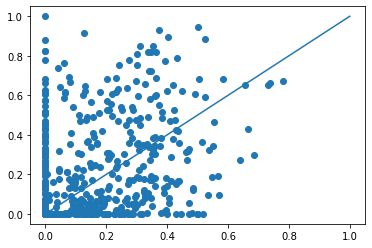

In [31]:
y_pred_ANN = modelANN.predict(X_val_flat)
plt.scatter(y_pred_ANN.flatten(), y_val.flatten())
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

## xgboost

In [32]:
#replace reg:linear with reg:squarederror; they should mean the same but the former throws warnings
seed(1)
multioutputregressor = MultiOutputRegressor(
    xgb.XGBRegressor(objective='reg:squarederror',
                     verbosity=1)
    ).fit(X_train_flat, y_train_flat) 

/home/judap/source/miniconda3/envs/ml-popex/lib/python3.8/site-packages/xgboost/data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [33]:
y_pred_XGB = multioutputregressor.predict(X_val_flat) 

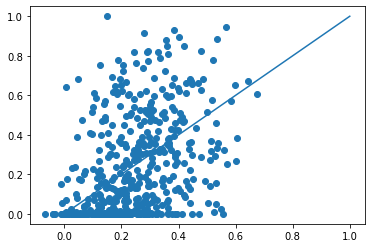

In [34]:
plt.scatter(y_pred_XGB.flatten(), y_val.flatten())
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

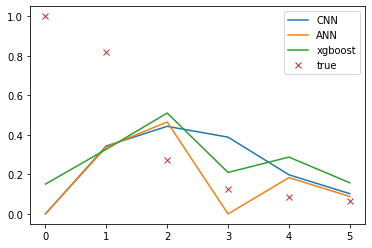

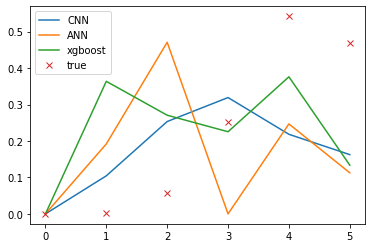

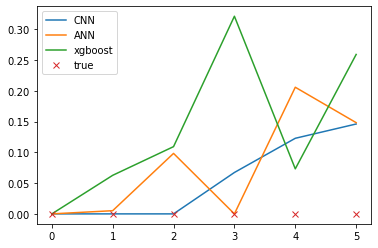

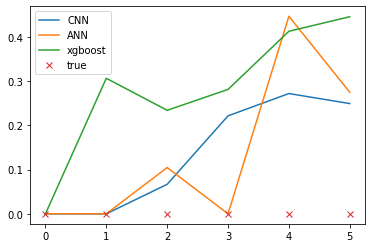

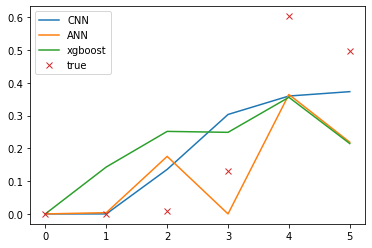

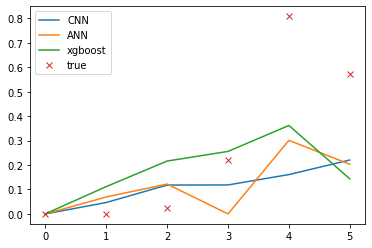

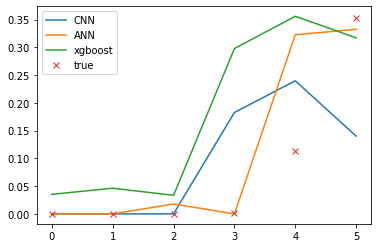

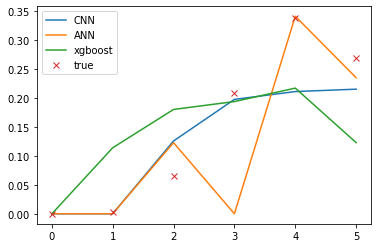

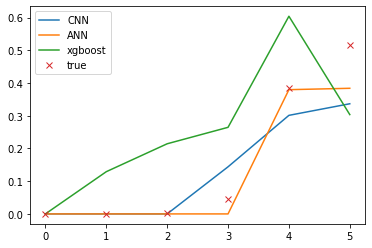

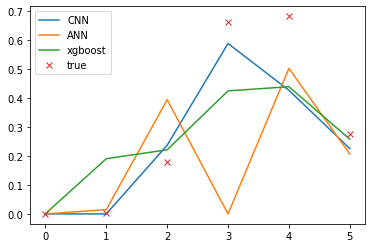

In [35]:
# plot some outputs
for i in range(10,20):
    plt.figure()
    plt.plot(y_pred_CNN[i,:])
    plt.plot(y_pred_ANN[i,:])
    plt.plot(y_pred_XGB[i,:])
    plt.plot(y_val[i,:], 'x')
    plt.legend(['CNN', 'ANN', 'xgboost', 'true'])